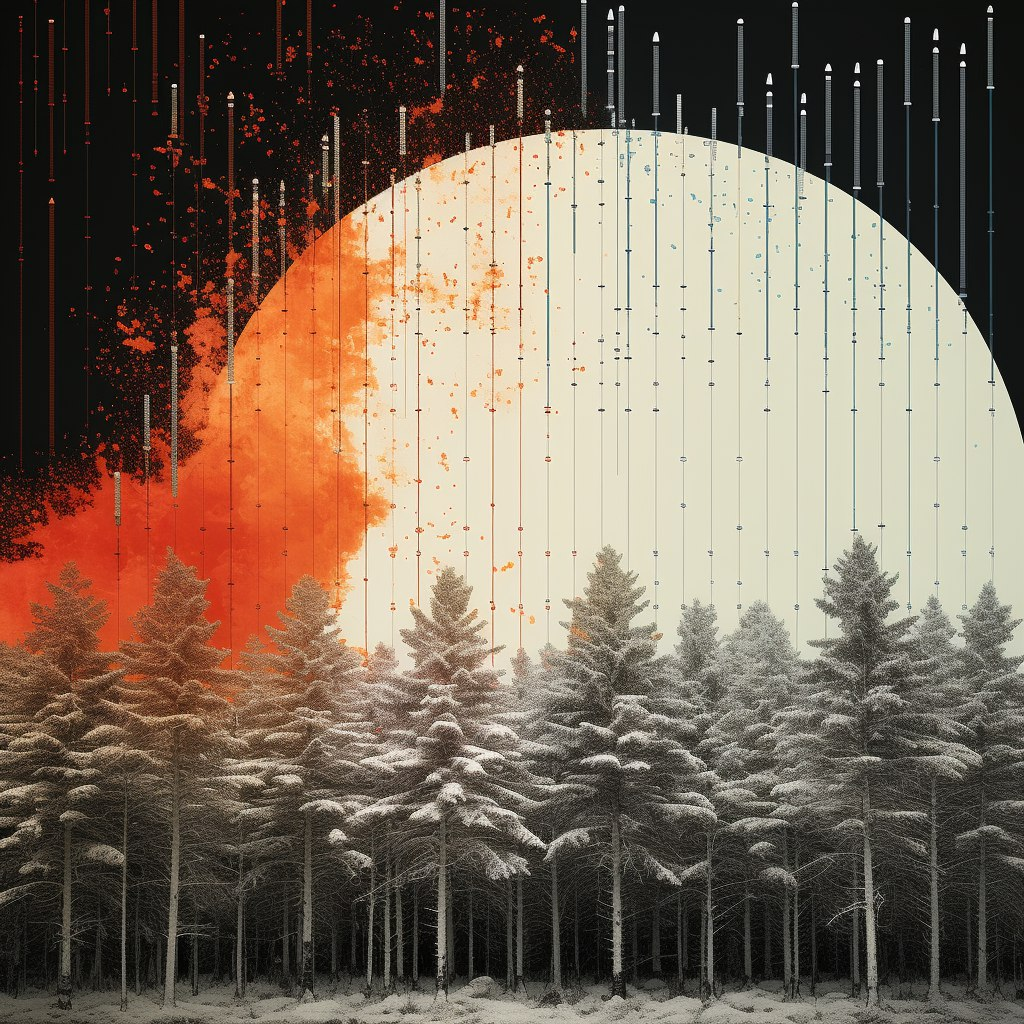
<center>
 <font color="gray"> Изображение сгенерировано Midjourney по запросу "случайный лес предсказывает погоду" </font> 

# <center> Предсказание погоды 

В этой работе мы немного коснёмся метеорологии, чтобы предсказать, будет ли дождь в Австралии. Попутно узнаем, какие факторы, по мнению наших моделей, сильнее влияют на вероятность дождя — возможно, эти знания можно применить для воспитания в себе интуиции метеоролога или шамана...

In [72]:
# Импортируем необходимый инструментарий
# Для работы с таблицами и числами
import pandas as pd 
import numpy as np

# Для моделирования
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn import metrics

# Для оптимизации моделей
import optuna

# Для графики и отображения
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

# Скрываем предупреждения
import warnings
warnings.filterwarnings('ignore')

## Загрузка и обработка данных

In [4]:
# weather data frame
wdf = pd.read_csv('data/weatherAUS.zip')
wdf.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Целевой переменной** является столбец `RainTomorrow` (наличие дождя на следующий день). Значение этой переменной мы и будем пытаться предсказать.

Подробная расшифровка всех признаков:

|features|description|features|description|
|-|-|-|-|
|`Date`|дата, в которую зафиксировано наблюдение|`WindSpeed9am`|скорость ветра в 9 часов утра|
|`Location`|местонахождение метеорологической станции|`WindSpeed3pm`|скорость ветра в 3 часа дня|
|`MinTemp`|минимальная температура (℃)|`Humidity9am`|влажность в 9 утра|
|`MaxTemp`|максимальная температура (℃)|`Humidity3pm`|влажность в 3 часа дня|
|`Rainfall`|количество осадков (дождь) за сутки (мм)|`Pressure9am`|атмосферное давление в 9 утра|
|`Evaporation`|количество испарений до 9 утра (мм)|`Pressure3pm`|атмосферное давление в 3 часа дня|
|`Sunshine`|количество часов в сутках, когда светило солнце|`Cloud9am`|часть неба, закрытая облаками, в 9 утра|
|`WindGustDir`|направление самого сильного порыва ветра за последние 24 часа|`Cloud3pm`|часть неба, закрытая облаками, в 3 часа дня|
|`WindGustSpeed`|скорость самого сильного порыва ветра за последние 24 часа|`Temp9am`|температура в 9 утра|
|`WindDir9am`|направление ветра в 9 утра|`Temp3pm`|температура в 3 часа дня|
|`WindDir3pm`|направление ветра в 3 часа дня|`RainToday`|наличие дождя в этот день|
|||||

In [5]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Данные содержат 23 признака и 145 460 наблюдений. Из этих 23 признаков шесть — категориальные, в одном записана дата, а остальные являются непрерывными числовыми данными.

- Примеры числовых признаков: температура, скорость ветра, влажность, облачность, атмосферное давление в разное время суток, количество осадков, испарение, количество часов с солнечной погодой.
- Примеры категориальных признаков: местоположение, направление ветра в разное время суток, наличие дождя сегодня или завтра.

Оценим также распределение классов.

Won't rain: 77.58%
Will rain: 22.42%


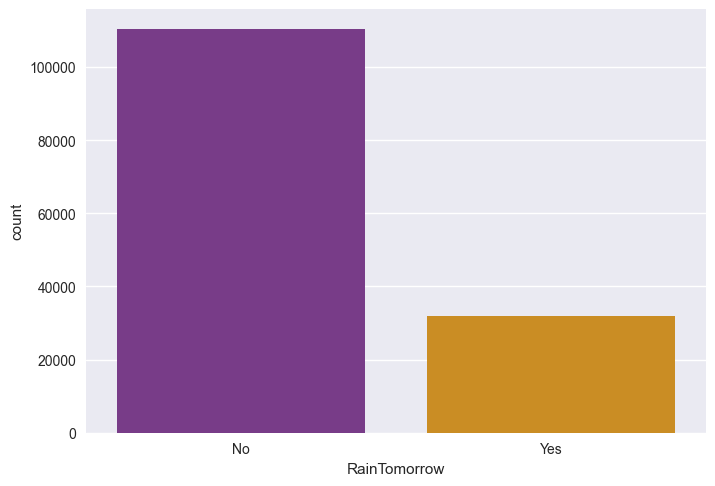

In [6]:
sns.countplot(x='RainTomorrow', data=wdf, palette='CMRmap')
class_percent = wdf['RainTomorrow'].value_counts(normalize=True) * 100
print("Won't rain: {:.2f}%".format(class_percent[0]))
print("Will rain: {:.2f}%".format(class_percent[1]))

Классы несбалансированы: при сплитовании выборок понадобится стратификация.

Взглянем на количество пропусков по признакам.

In [7]:
wdf.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [8]:
print(f'Общая сумма пропусков: {wdf.isna().sum().sum()}')

Общая сумма пропусков: 343248


В некоторых признаках пропусков более 40 % — от таких фич принято избавляться.

In [9]:
cols_with_na = wdf.isna().mean() * 100
cols_with_na = cols_with_na[cols_with_na > 40].sort_values(ascending=False)
cols_with_na

Sunshine       48.009762
Evaporation    43.166506
Cloud3pm       40.807095
dtype: float64

In [10]:
# Удаляем эти три колонки из таблицы
wdf.drop(list(cols_with_na.index), axis=1, inplace=True)

Теперь обработаем признаки `RainToday` и `RainTomorrow` таким образом, чтобы вместо `yes` было значение `1`, а вместо `no` — значение `0`.

In [11]:
wdf['RainToday'] = wdf['RainToday'].apply(
    lambda x: ['No', 'Yes'].index(x) if x in ['No', 'Yes'] else x
)
wdf['RainTomorrow'] = wdf['RainTomorrow'].apply(
    lambda x: ['No', 'Yes'].index(x) if x in ['No', 'Yes'] else x
)

Обработаем признак `Date` таким образом, чтобы выделить в отдельный признак `Month` (номер месяца). Изначальный признак `Date` удалим за ненадобностью.

In [12]:
wdf['Date'] = pd.to_datetime(wdf['Date'])
wdf['Month'] = wdf['Date'].dt.month.astype('category')
wdf.drop('Date', axis=1, inplace=True)

Определим, какой месяц имеет самую большую часть дождливых дней относительно всех дней месяца.

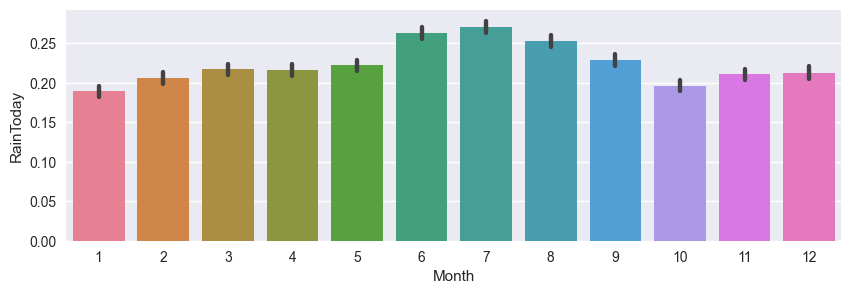

In [13]:
# Зададим фигуру и поля
fig, ax = plt.subplots(figsize=(10, 3))
# Рисуем графику
sns.barplot(
    data=wdf, x="Month",
    y='RainToday', palette='husl', ax=ax
);

Дождей, судя по всему, в Австралии больше всего выпадает в июне: на той стороне Земли, где все ходят вверх ногами, и на лето наше вовсе приходится зима.

Обработаем оставшиеся категориальные признаки.

In [14]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
wdf_dummies = pd.get_dummies(wdf, columns=categoricals)
# Размер получившегося датасета
wdf_dummies.shape

(145460, 124)

Теперь удалим все строки, где есть пропуски, — благо, число наблюдений довольно велико, и мы можем себе позволить такую грубость. 

Далее разобьем данные на обучающую и тестовую выборки в соотношении 70/30.

In [15]:
wdf_cleaned = wdf_dummies.dropna()
X = wdf_cleaned.drop('RainTomorrow', axis=1)
y = wdf_cleaned['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_train.shape, X_test.shape

((54779, 123), (23478, 123))

Осталось лишь стандартизировать данные.

In [16]:
scaler = StandardScaler()
trainX_scaled = scaler.fit_transform(X_train)
testX_scaled = scaler.transform(X_test)

## Моделирование

Дабы избежать дублирования пространного кода сразу напишем отдельную функцию для получения значений метрик.

In [17]:
# Напишем одну полезную функцию
def metrics_extraction(preds_train, preds_test, train_y, test_y):
    """
    Функция для получения массива значений метрик для
    их дальнейшей печати и предачи в сводную таблицу.
    Args:
        preds_train (np.array): вектор предсказанных значений train-выборки;
        preds_test (np.array): вектор предсказанных значений test-выборки;
        train_y (np.array): вектор истинных значений train-выборки;
        test_y (np.array): вектор истинных значений test-выборки.
    Returns:
        tuple: 
            list: список строк для вывода метрик треннировочной выборки,
            list: список строк для вывода метрик тествовой выборки,
            array: вектор метрик треннировочной выборки,
            array: вектор метрик тествовой выборки.
    """
    
    precision_train = metrics.precision_score(train_y, preds_train)
    precision_test = metrics.precision_score(test_y, preds_test)
    recall_train = metrics.recall_score(train_y, preds_train)
    recall_test = metrics.recall_score(test_y, preds_test)
    f1_train = metrics.f1_score(train_y, preds_train)
    f1_test = metrics.f1_score(test_y, preds_test)
    accuracy_train = metrics.accuracy_score(train_y, preds_train)
    accuracy_test = metrics.accuracy_score(test_y, preds_test)
    roc_auc_train = metrics.roc_auc_score(train_y, preds_train)
    roc_auc_test = metrics.roc_auc_score(test_y, preds_test)
    
    train_print_lst = [
        'Train metrics:',
        f'Precision: {round(precision_train, 3)}',
        f'Recall:    {round(recall_train, 3)}',
        f'F1 score:  {round(f1_train, 3)}',
        f'Accuracy:  {round(accuracy_train, 3)}',
        f'ROC-AUC:   {round(roc_auc_train, 3)}'
    ]
    
    test_print_lst = [
        'Test metrics:',
        f'Precision: {round(precision_test, 3)}',
        f'Recall:    {round(recall_test, 3)}',
        f'F1 score:  {round(f1_test, 3)}',
        f'Accuracy:  {round(accuracy_test, 3)}',
        f'ROC-AUC:   {round(roc_auc_test, 3)}'
    ]
    
    train_array = np.array([
        precision_train, recall_train, f1_train, accuracy_train, roc_auc_train
    ])
    
    test_array = np.array([
        precision_test, recall_test, f1_test, accuracy_test, roc_auc_test
    ])
    
    return train_print_lst, test_print_lst, train_array, test_array
    

### Baseline model (LogisticRegression)

Начнём с того, что построим простейшую логистическую регрессию (без настройки гиперпараметров). Это будет наш baseline model.

In [18]:
# Инициализируем объект LogisticRegression
base_logr = LogisticRegression(random_state=42)
# Обучение
base_logr.fit(trainX_scaled, y_train)
# Предсказания
preds_train_base_logr = base_logr.predict(trainX_scaled)
preds_test_base_logr = base_logr.predict(testX_scaled)

# Получение метрик
train_print_logr, test_print_logr, train_array_logr, test_array_logr = metrics_extraction(
    preds_train_base_logr, preds_test_base_logr, y_train, y_test
)

# Вывод метрик
print(*train_print_logr, sep='\n', end='\n\n')
print(*test_print_logr, sep='\n')

Train metrics:
Precision: 0.739
Recall:    0.539
F1 score:  0.623
Accuracy:  0.852
ROC-AUC:   0.741

Test metrics:
Precision: 0.744
Recall:    0.538
F1 score:  0.624
Accuracy:  0.853
ROC-AUC:   0.742


Для наглядности выведем отчет по классам для тестовой выборки.

In [19]:
print(metrics.classification_report(y_test, preds_test_base_logr, digits=3))

              precision    recall  f1-score   support

         0.0      0.874     0.946     0.909     18141
         1.0      0.744     0.538     0.624      5337

    accuracy                          0.853     23478
   macro avg      0.809     0.742     0.766     23478
weighted avg      0.845     0.853     0.844     23478



Метрика полноты (recall) выглядит малоудовлетворительной: модель довольно часто допускает ошибку второго рода, проявляет неразборчивость к объектам класса 1, т.е. часто не видит оснований утверждать о завтрашнем дожде.

### GaussianNB

In [20]:
# Инициализация объекта
gnb = GaussianNB()
# Обучение
gnb.fit(trainX_scaled, y_train)
# Предсказания
gnb_preds_train = gnb.predict(trainX_scaled)
gnb_preds_test = gnb.predict(testX_scaled)

# Получение метрик
train_print_gnb, test_print_gnb, train_array_gnb, test_array_gnb = metrics_extraction(
    gnb_preds_train, gnb_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_gnb, sep='\n', end='\n\n')
print(*test_print_gnb, sep='\n')

Train metrics:
Precision: 0.4
Recall:    0.683
F1 score:  0.505
Accuracy:  0.695
ROC-AUC:   0.691

Test metrics:
Precision: 0.401
Recall:    0.68
F1 score:  0.504
Accuracy:  0.696
ROC-AUC:   0.69


Выведем более подробный отчет.

In [21]:
print(metrics.classification_report(y_test, gnb_preds_test, digits=3))

              precision    recall  f1-score   support

         0.0      0.882     0.701     0.781     18141
         1.0      0.401     0.680     0.504      5337

    accuracy                          0.696     23478
   macro avg      0.641     0.690     0.643     23478
weighted avg      0.772     0.696     0.718     23478



К сожалению, в нашем случае модель, основанная на алгоритме наивного байесовского классификатора, оказалась подверженной другому изьяну, нежели модель на логистической регрессии: она, в отличие от второго, наоборот слишком пессимистична в отношении хорошей погоды на завтра — о чем свидетельсвует показатель точности (precision): из всех ее предсказаний на завтра дождя сбываются лишь 40%. Однако эта модель, в отличие от базовой, полнее охватывает объекты класса 1, т.е. лишь 32% дождей на следующий день оказываются ею не предсказанными.

Оптимизацию использованного здесь алгоритма мы проводить не будем: впереди нас ожидают более интересные случаи.

### KNeighborsClassifier

In [22]:
# Инициализация объекта
knn = KNeighborsClassifier()
# Обучение
knn.fit(trainX_scaled, y_train)
# Предсказания
knn_preds_train = knn.predict(trainX_scaled)
knn_preds_test = knn.predict(testX_scaled)

# Получение метрик
train_print_knn, test_print_knn, train_array_knn, test_array_knn = metrics_extraction(
    knn_preds_train, knn_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_knn, sep='\n', end='\n\n')
print(*test_print_knn, sep='\n')

Train metrics:
Precision: 0.801
Recall:    0.476
F1 score:  0.597
Accuracy:  0.854
ROC-AUC:   0.721

Test metrics:
Precision: 0.606
Recall:    0.322
F1 score:  0.42
Accuracy:  0.798
ROC-AUC:   0.63


In [23]:
print(metrics.classification_report(y_test, knn_preds_test, digits=3))

              precision    recall  f1-score   support

         0.0      0.825     0.938     0.878     18141
         1.0      0.606     0.322     0.420      5337

    accuracy                          0.798     23478
   macro avg      0.715     0.630     0.649     23478
weighted avg      0.775     0.798     0.774     23478



Эта модель проявляет куда более серьезную близорукость, нежели базовая: намного менее чувствительна к предвестникам дождя. Оптимизировать ее алгоритм под нашу задачу мы тоже не станем.

### LinearSVC

Классификация линейных опорных векторов.

In [24]:
# Инициализация объекта
lin_svc = LinearSVC(random_state=42)
# Обучение
lin_svc.fit(trainX_scaled, y_train)
# Предсказания
lin_svc_preds_train = lin_svc.predict(trainX_scaled)
lin_svc_preds_test = lin_svc.predict(testX_scaled)

# Получение метрик
train_print_lin_svc, test_print_lin_svc, train_array_lin_svc, test_array_lin_svc = metrics_extraction(
    lin_svc_preds_train, lin_svc_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_lin_svc, sep='\n', end='\n\n')
print(*test_print_lin_svc, sep='\n')

Train metrics:
Precision: 0.751
Recall:    0.52
F1 score:  0.615
Accuracy:  0.852
ROC-AUC:   0.735

Test metrics:
Precision: 0.754
Recall:    0.519
F1 score:  0.615
Accuracy:  0.852
ROC-AUC:   0.735


Теперь мы получили результаты сопоставимые с теми, что дала базовая модель.

### SVC

Классификация C-опорных векторов.

In [25]:
# Инициализация объекта
svc_model = SVC(random_state=42)
# Обучение
svc_model.fit(trainX_scaled, y_train)
# Предсказания
svc_preds_train = svc_model.predict(trainX_scaled)
svc_preds_test = svc_model.predict(testX_scaled)

# Получение метрик
train_print_svc, test_print_svc, train_array_svc, test_array_svc = metrics_extraction(
    svc_preds_train, svc_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_svc, sep='\n', end='\n\n')
print(*test_print_svc, sep='\n')

Train metrics:
Precision: 0.872
Recall:    0.635
F1 score:  0.735
Accuracy:  0.896
ROC-AUC:   0.804

Test metrics:
Precision: 0.776
Recall:    0.546
F1 score:  0.641
Accuracy:  0.861
ROC-AUC:   0.75


Несколько лучше базовой модели, но recall все еще довольно низок.

### SGDClassifier

In [26]:
# Инициализация объекта
sgdc = SGDClassifier(random_state=42)
# Обучение
sgdc.fit(trainX_scaled, y_train)
# Предсказания
sgdc_preds_train = sgdc.predict(trainX_scaled)
sgdc_preds_test = sgdc.predict(testX_scaled)

# Получение метрик
train_print_sgdc, test_print_sgdc, train_array_sgdc, test_array_sgdc = metrics_extraction(
    sgdc_preds_train, sgdc_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_sgdc, sep='\n', end='\n\n')
print(*test_print_sgdc, sep='\n')

Train metrics:
Precision: 0.744
Recall:    0.515
F1 score:  0.608
Accuracy:  0.849
ROC-AUC:   0.731

Test metrics:
Precision: 0.738
Recall:    0.507
F1 score:  0.601
Accuracy:  0.847
ROC-AUC:   0.727


Также получаем около-базовые характеристики, даже чуть хуже.

### MLPClassifier

Рассмотрим также базовый нейросетевой алгоритм — классификатор многослойного персептрона.

In [27]:
# Инициализация объекта
mlpc = MLPClassifier(random_state=42)
# Обучение
mlpc.fit(trainX_scaled, y_train)
# Предсказания
mlpc_preds_train = mlpc.predict(trainX_scaled)
mlpc_preds_test = mlpc.predict(testX_scaled)

# Получение метрик
train_print_mlpc, test_print_mlpc, train_array_mlpc, test_array_mlpc = metrics_extraction(
    mlpc_preds_train, mlpc_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_mlpc, sep='\n', end='\n\n')
print(*test_print_mlpc, sep='\n')

Train metrics:
Precision: 0.905
Recall:    0.851
F1 score:  0.877
Accuracy:  0.946
ROC-AUC:   0.912

Test metrics:
Precision: 0.635
Recall:    0.602
F1 score:  0.618
Accuracy:  0.831
ROC-AUC:   0.75


И мы сразу сталкиваемся с самой распространенной проблемой нейросетей — переобучение: метрики на треннировочной выборке сильно превосходят тестовые.

In [28]:
print(metrics.classification_report(y_test, mlpc_preds_test, digits=3))

              precision    recall  f1-score   support

         0.0      0.885     0.898     0.891     18141
         1.0      0.635     0.602     0.618      5337

    accuracy                          0.831     23478
   macro avg      0.760     0.750     0.755     23478
weighted avg      0.828     0.831     0.829     23478



Однако данную модель отличает от предыдущих некоторая претензия на сбалансированность показателей полноты и точности.

### Optuna(MLPClassifier)

In [64]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_mlp(trial):
    """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [
        (80, 40), (80, 30), (80, 20),
        (60, 40), (60, 30), (60, 20),
        (50, 30), (50, 25), (50, 15),
    ])
    activation = trial.suggest_categorical('activation', ['identity', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['sgd', 'adam'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2)
    # Создаем модель
    model=MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=500,
        random_state=42        
    )   
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, trainX_scaled, y_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_mlp = optuna.create_study(study_name="mlp_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_mlp.optimize(optuna_mlp, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_mlp = MLPClassifier(**study_mlp.best_params, random_state=42)
# Обучение
opt_mlp.fit(trainX_scaled, y_train)
# Предсказания
preds_train_opt_mlp = opt_mlp.predict(trainX_scaled)
preds_test_opt_mlp = opt_mlp.predict(testX_scaled)

# Получение метрик
train_print_opt_mlp, test_print_opt_mlp, train_array_opt_mlp, test_array_opt_mlp = metrics_extraction(
    preds_train_opt_mlp, preds_test_opt_mlp, y_train, y_test
)

# Вывод метрик
print(*train_print_opt_mlp, sep='\n', end='\n\n')
print(*test_print_opt_mlp, sep='\n')
print(f'Лучшие гиперпараметры: {study_mlp.best_params}')

Train metrics:
Precision: 0.801
Recall:    0.655
F1 score:  0.72
Accuracy:  0.884
ROC-AUC:   0.803

Test metrics:
Precision: 0.735
Recall:    0.597
F1 score:  0.659
Accuracy:  0.86
ROC-AUC:   0.767
Лучшие гиперпараметры: {'hidden_layer_sizes': (50, 30), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.006116677251666324}
CPU times: total: 52.4 s
Wall time: 15min 46s


Теперь модель совсем не кажется переобученной, однако баланса точности и полноты уже не имеется. И все же модель получилась лучше базовой.

Также можно взглянуть на кривую потерь.

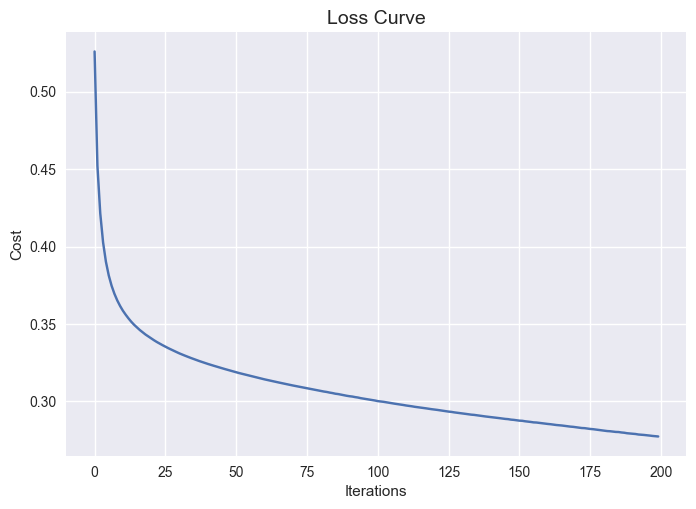

In [65]:
plt.plot(opt_mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### DecisionTreeClassifier

In [31]:
# Инициализация объекта
dtc = DecisionTreeClassifier(random_state=42)
# Обучение
dtc.fit(trainX_scaled, y_train)
# Предсказания
dtc_preds_train = dtc.predict(trainX_scaled)
dtc_preds_test = dtc.predict(testX_scaled)

# Получение метрик
train_print_dtc, test_print_dtc, train_array_dtc, test_array_dtc = metrics_extraction(
    dtc_preds_train, dtc_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_dtc, sep='\n', end='\n\n')
print(*test_print_dtc, sep='\n')

Train metrics:
Precision: 1.0
Recall:    1.0
F1 score:  1.0
Accuracy:  1.0
ROC-AUC:   1.0

Test metrics:
Precision: 0.544
Recall:    0.555
F1 score:  0.549
Accuracy:  0.793
ROC-AUC:   0.709


In [32]:
# Выведем характеристики дерева
print(
    f'Глубина дерева: {dtc.get_depth()}',
    f'Число листьев:  {dtc.get_n_leaves()}',
    sep='\n'
)

Глубина дерева: 37
Число листьев:  6284


Алгоритм, разумеется, переобучен. Будем оптимизировать.

### Optuna(DecisionTreeClassifier)

In [33]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_dtc(trial):
    """Функция, обучающая модель DecisionTreeClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 37)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 51, 2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Создаем модель
    model=DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42        
    )   
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, trainX_scaled, y_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_dtc = optuna.create_study(study_name="dtc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_dtc.optimize(optuna_dtc, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_dtc = DecisionTreeClassifier(**study_dtc.best_params, random_state=42)
# Обучение
opt_dtc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_opt_dtc = opt_dtc.predict(trainX_scaled)
preds_test_opt_dtc = opt_dtc.predict(testX_scaled)

# Получение метрик
train_print_opt_dtc, test_print_opt_dtc, train_array_opt_dtc, test_array_opt_dtc = metrics_extraction(
    preds_train_opt_dtc, preds_test_opt_dtc, y_train, y_test
)

# Вывод метрик
print(*train_print_opt_dtc, sep='\n', end='\n\n')
print(*test_print_opt_dtc, sep='\n')
print(f'Лучшие гиперпараметры: {study_dtc.best_params}')

Train metrics:
Precision: 0.729
Recall:    0.501
F1 score:  0.594
Accuracy:  0.844
ROC-AUC:   0.723

Test metrics:
Precision: 0.723
Recall:    0.499
F1 score:  0.591
Accuracy:  0.843
ROC-AUC:   0.722
Лучшие гиперпараметры: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}
CPU times: total: 1.25 s
Wall time: 19.4 s


Получилось улучшить модель на алгоритме дерева решений, однако базовая модель осталась не пробитой.

### AdaBoostClassifier

In [34]:
# Инициализация объекта
abc = AdaBoostClassifier(random_state=42)
# Обучение
abc.fit(trainX_scaled, y_train)
# Предсказания
abc_preds_train = abc.predict(trainX_scaled)
abc_preds_test = abc.predict(testX_scaled)

# Получение метрик
train_print_abc, test_print_abc, train_array_abc, test_array_abc = metrics_extraction(
    abc_preds_train, abc_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_abc, sep='\n', end='\n\n')
print(*test_print_abc, sep='\n')

Train metrics:
Precision: 0.733
Recall:    0.515
F1 score:  0.605
Accuracy:  0.847
ROC-AUC:   0.73

Test metrics:
Precision: 0.729
Recall:    0.513
F1 score:  0.602
Accuracy:  0.846
ROC-AUC:   0.728


Модель на алгоритме адаптивного бустинга с дефолтными параметрами базовую модель преодолеть не смогла.

### AdaBoostClassifier on Optuna(DecisionTreeClassifier)

Попробуем собрать лес адаптивного бустинга из клонов уже оптимизированного дерева решений.

In [35]:
# Инициализация объекта
abc_on_opt_dtc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        **study_dtc.best_params,
        random_state=42
    ),
    n_estimators=100
)
# Обучение
abc_on_opt_dtc.fit(trainX_scaled, y_train)
# Предсказания
abc2_preds_train = abc_on_opt_dtc.predict(trainX_scaled)
abc2_preds_test = abc_on_opt_dtc.predict(testX_scaled)

# Получение метрик
train_print_abc2, test_print_abc2, train_array_abc2, test_array_abc2 = metrics_extraction(
    abc2_preds_train, abc2_preds_test, y_train, y_test
)

# Вывод метрик
print(*train_print_abc2, sep='\n', end='\n\n')
print(*test_print_abc2, sep='\n')

Train metrics:
Precision: 0.922
Recall:    0.856
F1 score:  0.888
Accuracy:  0.951
ROC-AUC:   0.917

Test metrics:
Precision: 0.638
Recall:    0.559
F1 score:  0.596
Accuracy:  0.828
ROC-AUC:   0.733


Разумеется, алгоритм переобучен и базовая модель также осталась сильней.

### Optuna(AdaBoostClassifier)

In [36]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_abc(trial):
    """Функция, обучающая модель AdaBoostClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 37)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 51, 2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 150, 200])

    # Создаем модель
    model=AdaBoostClassifier(
        DecisionTreeClassifier(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ),
        n_estimators=n_estimators
    )
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, trainX_scaled, y_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_abc = optuna.create_study(study_name="abc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_abc.optimize(optuna_abc, n_trials=10)

print(f'Лучшие гиперпараметры: {study_abc.best_params}')

Лучшие гиперпараметры: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 12, 'n_estimators': 200}
CPU times: total: 328 ms
Wall time: 11min 48s


In [37]:
# Передаем модели коллекцию оптимальных гиперпараметров
opt_abc = AdaBoostClassifier(DecisionTreeClassifier(
            criterion='entropy',
            splitter='best',
            max_depth=2,
            min_samples_split=20,
            min_samples_leaf=4,
            random_state=42
        ),
        n_estimators=150
)
# Обучение
opt_abc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_opt_abc = opt_abc.predict(trainX_scaled)
preds_test_opt_abc = opt_abc.predict(testX_scaled)

# Получение метрик
train_print_opt_abc, test_print_opt_abc, train_array_opt_abc, test_array_opt_abc = metrics_extraction(
    preds_train_opt_abc, preds_test_opt_abc, y_train, y_test
)

# Вывод метрик
print(*train_print_opt_abc, sep='\n', end='\n\n')
print(*test_print_opt_abc, sep='\n')

Train metrics:
Precision: 0.757
Recall:    0.584
F1 score:  0.659
Accuracy:  0.863
ROC-AUC:   0.764

Test metrics:
Precision: 0.726
Recall:    0.56
F1 score:  0.633
Accuracy:  0.852
ROC-AUC:   0.749


Оптимизированный адаптивный бустинг сумел улучшить recall (base_model: 0.538), f1 (base_model: 0.624) и roc-auc (base_model: 0.742).

### RandomForestClassifier

In [38]:
# Инициализация объекта
rfc = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)
# Обучение
rfc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_rfc = rfc.predict(trainX_scaled)
preds_test_rfc = rfc.predict(testX_scaled)

# Получение метрик
train_print_rfc, test_print_rfc, train_array_rfc, test_array_rfc = metrics_extraction(
    preds_train_rfc, preds_test_rfc, y_train, y_test
)

# Вывод метрик
print(*train_print_rfc, sep='\n', end='\n\n')
print(*test_print_rfc, sep='\n')

Train metrics:
Precision: 1.0
Recall:    1.0
F1 score:  1.0
Accuracy:  1.0
ROC-AUC:   1.0

Test metrics:
Precision: 0.78
Recall:    0.513
F1 score:  0.619
Accuracy:  0.856
ROC-AUC:   0.735


Алгоритм переобучен, но precision (base_model: 0.744) и accuracy (base_model: 0.853) уже лучше, чем у базовой модели.

### Optuna(RandomForestClassifier)

In [39]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_rfc(trial):
    """Функция, обучающая модель RandomForestClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    n_estimators = trial.suggest_int('n_estimators', 40, 400, 20)
    max_depth = trial.suggest_int('max_depth', 2, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, 1)

    # Создаем модель
    model=RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, trainX_scaled, y_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_rfc = optuna.create_study(study_name="rfc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rfc.optimize(optuna_rfc, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_rfc = RandomForestClassifier(**study_rfc.best_params, random_state=42)
# Обучение
opt_rfc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_opt_rfc = opt_rfc.predict(trainX_scaled)
preds_test_opt_rfc = opt_rfc.predict(testX_scaled)

# Получение метрик
train_print_opt_rfc, test_print_opt_rfc, train_array_opt_rfc, test_array_opt_rfc = metrics_extraction(
    preds_train_opt_rfc, preds_test_opt_rfc, y_train, y_test
)

# Вывод метрик
print(*train_print_opt_rfc, sep='\n', end='\n\n')
print(*test_print_opt_rfc, sep='\n')
print(f'Лучшие гиперпараметры: {study_rfc.best_params}')

Train metrics:
Precision: 0.99
Recall:    0.845
F1 score:  0.912
Accuracy:  0.963
ROC-AUC:   0.921

Test metrics:
Precision: 0.772
Recall:    0.507
F1 score:  0.612
Accuracy:  0.854
ROC-AUC:   0.732
Лучшие гиперпараметры: {'criterion': 'gini', 'n_estimators': 180, 'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 2}
CPU times: total: 21.9 s
Wall time: 3min 21s


Пожалуй, оптимизация случайного леса в нашем случае безрезультатна.

### GradientBoostingClassifier

In [40]:
# Инициализация объекта
gbc = GradientBoostingClassifier(
    random_state=42
)
# Обучение
gbc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_gbc = gbc.predict(trainX_scaled)
preds_test_gbc = gbc.predict(testX_scaled)

# Получение метрик
train_print_gbc, test_print_gbc, train_array_gbc, test_array_gbc = metrics_extraction(
    preds_train_gbc, preds_test_gbc, y_train, y_test
)

# Вывод метрик
print(*train_print_gbc, sep='\n', end='\n\n')
print(*test_print_gbc, sep='\n')

Train metrics:
Precision: 0.763
Recall:    0.526
F1 score:  0.623
Accuracy:  0.855
ROC-AUC:   0.739

Test metrics:
Precision: 0.76
Recall:    0.518
F1 score:  0.616
Accuracy:  0.853
ROC-AUC:   0.735


Снова не особенно впечатляющие результаты. Попробуем оптимизировать.

### Optuna(GradientBoostingClassifier)

In [41]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_gbc(trial):
    """Функция, обучающая модель GradientBoostingClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 10)
    n_estimators = trial.suggest_int('n_estimators', 1, 151, 2)
    subsample = trial.suggest_float('subsample', 1e-2, 1)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)
    max_depth = trial.suggest_int('max_depth', 2, 10, 1)

    # Создаем модель
    model=GradientBoostingClassifier(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, trainX_scaled, y_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_gbc = optuna.create_study(study_name="gbc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_gbc.optimize(optuna_gbc, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_gbc = GradientBoostingClassifier(**study_gbc.best_params, random_state=42)
# Обучение
opt_gbc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_opt_gbc = opt_gbc.predict(trainX_scaled)
preds_test_opt_gbc = opt_gbc.predict(testX_scaled)

# Получение метрик
train_print_opt_gbc, test_print_opt_gbc, train_array_opt_gbc, test_array_opt_gbc = metrics_extraction(
    preds_train_opt_gbc, preds_test_opt_gbc, y_train, y_test
)

# Вывод метрик
print(*train_print_opt_gbc, sep='\n', end='\n\n')
print(*test_print_opt_gbc, sep='\n')
print(f'Лучшие гиперпараметры: {study_gbc.best_params}')

Train metrics:
Precision: 0.738
Recall:    0.567
F1 score:  0.641
Accuracy:  0.856
ROC-AUC:   0.754

Test metrics:
Precision: 0.725
Recall:    0.555
F1 score:  0.629
Accuracy:  0.851
ROC-AUC:   0.747
Лучшие гиперпараметры: {'loss': 'exponential', 'learning_rate': 0.9497965444008752, 'n_estimators': 33, 'subsample': 0.721535899269833, 'criterion': 'squared_error', 'min_samples_split': 22, 'min_samples_leaf': 14, 'max_depth': 3}
CPU times: total: 4.05 s
Wall time: 4min 30s


А эта модель уже несколько лучше базовой.

### HistGradientBoostingClassifier

In [42]:
# Инициализация объекта
hgbc = HistGradientBoostingClassifier(
    random_state=42
)
# Обучение
hgbc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_hgbc = hgbc.predict(trainX_scaled)
preds_test_hgbc = hgbc.predict(testX_scaled)

# Получение метрик
train_print_hgbc, test_print_hgbc, train_array_hgbc, test_array_hgbc = metrics_extraction(
    preds_train_hgbc, preds_test_hgbc, y_train, y_test
)

# Вывод метрик
print(*train_print_hgbc, sep='\n', end='\n\n')
print(*test_print_hgbc, sep='\n')

Train metrics:
Precision: 0.8
Recall:    0.596
F1 score:  0.683
Accuracy:  0.874
ROC-AUC:   0.776

Test metrics:
Precision: 0.758
Recall:    0.559
F1 score:  0.643
Accuracy:  0.859
ROC-AUC:   0.753


Удалось превзойти базовую модель без оптимизации. Но мы все же проверим и этот путь.

### Optuna(HistGradientBoostingClassifier)

In [43]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_hgbc(trial):
    """Функция, обучающая модель HistGradientBoostingClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1)
    max_iter = trial.suggest_int('max_iter', 50, 300, 25)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 50, 2)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 51, 2)
    l2_regularization = trial.suggest_float('l2_regularization', 0, 1)

    # Создаем модель
    model=HistGradientBoostingClassifier(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_leaf_nodes=max_leaf_nodes,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        l2_regularization=l2_regularization,
        random_state=42
    )
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, trainX_scaled, y_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_hgbc = optuna.create_study(study_name="hgbc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_hgbc.optimize(optuna_hgbc, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_hgbc = HistGradientBoostingClassifier(**study_hgbc.best_params, random_state=42)
# Обучение
opt_hgbc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_opt_hgbc = opt_hgbc.predict(trainX_scaled)
preds_test_opt_hgbc = opt_hgbc.predict(testX_scaled)

# Получение метрик
train_print_opt_hgbc, test_print_opt_hgbc, train_array_opt_hgbc, test_array_opt_hgbc = metrics_extraction(
    preds_train_opt_hgbc, preds_test_opt_hgbc, y_train, y_test
)

# Вывод метрик
print(*train_print_opt_hgbc, sep='\n', end='\n\n')
print(*test_print_opt_hgbc, sep='\n')
print(f'Лучшие гиперпараметры: {study_hgbc.best_params}')

Train metrics:
Precision: 0.838
Recall:    0.64
F1 score:  0.726
Accuracy:  0.89
ROC-AUC:   0.802

Test metrics:
Precision: 0.762
Recall:    0.573
F1 score:  0.654
Accuracy:  0.862
ROC-AUC:   0.76
Лучшие гиперпараметры: {'learning_rate': 0.10096385095671959, 'max_iter': 125, 'max_leaf_nodes': 50, 'max_depth': 12, 'min_samples_leaf': 13, 'l2_regularization': 0.7372418943548124}
CPU times: total: 16.9 s
Wall time: 1min 2s


Модель стала чуть лучше.

### StackingClassifier

In [44]:
# Список моделей для стэка
estimators = [
    ('gnb', GaussianNB()),
    ('knn', KNeighborsClassifier()),
    ('lin_svc', LinearSVC(random_state=42)),
    ('svc', SVC(random_state=42)),
    ('sgdc', SGDClassifier(random_state=42)),
    ('opt_mlp', MLPClassifier(**study_mlp.best_params, random_state=42)),
    ('opt_abc', AdaBoostClassifier(
        DecisionTreeClassifier(
            criterion='entropy',
            splitter='best',
            max_depth=2,
            min_samples_split=20,
            min_samples_leaf=4,
            random_state=42
            ),
        n_estimators=150)
    ),
    ('rfc', RandomForestClassifier(
        random_state=42,
        n_jobs=-1)
    ),
    ('opt_gbc', GradientBoostingClassifier(
        **study_gbc.best_params,
        random_state=42
        )
    ),
    ('opt_hgbc', HistGradientBoostingClassifier(
        **study_hgbc.best_params,
        random_state=42
        )
    )
]
# Инициализация объекта
sc_metamodel = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        random_state=42
    ),
    n_jobs=-1
)
# Обучение
sc_metamodel.fit(trainX_scaled, y_train)
# Предсказания
preds_train_scmm = sc_metamodel.predict(trainX_scaled)
preds_test_scmm = sc_metamodel.predict(testX_scaled)

# Получение метрик
train_print_scmm, test_print_scmm, train_array_scmm, test_array_scmm = metrics_extraction(
    preds_train_scmm, preds_test_scmm, y_train, y_test
)

# Вывод метрик
print(*train_print_scmm, sep='\n', end='\n\n')
print(*test_print_scmm, sep='\n')

Train metrics:
Precision: 0.937
Recall:    0.786
F1 score:  0.855
Accuracy:  0.939
ROC-AUC:   0.885

Test metrics:
Precision: 0.772
Recall:    0.577
F1 score:  0.661
Accuracy:  0.865
ROC-AUC:   0.764


У нас получилось настэкать весьма неплохую модель.

### XGBClassifier

In [45]:
# Инициализация объекта
xgbc = XGBClassifier(
    random_state=42
)
# Обучение
xgbc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_xgbc = xgbc.predict(trainX_scaled)
preds_test_xgbc = xgbc.predict(testX_scaled)

# Получение метрик
train_print_xgbc, test_print_xgbc, train_array_xgbc, test_array_xgbc = metrics_extraction(
    preds_train_xgbc, preds_test_xgbc, y_train, y_test
)

# Вывод метрик
print(*train_print_xgbc, sep='\n', end='\n\n')
print(*test_print_xgbc, sep='\n')

Train metrics:
Precision: 0.877
Recall:    0.692
F1 score:  0.773
Accuracy:  0.908
ROC-AUC:   0.832

Test metrics:
Precision: 0.754
Recall:    0.58
F1 score:  0.656
Accuracy:  0.862
ROC-AUC:   0.762


### CatBoostClassifier

In [46]:
# Инициализация объекта
cbc = CatBoostClassifier(
    verbose=False,
    random_state=42
)
# Обучение
cbc.fit(trainX_scaled, y_train)
# Предсказания
preds_train_cbc = cbc.predict(trainX_scaled)
preds_test_cbc = cbc.predict(testX_scaled)

# Получение метрик
train_print_cbc, test_print_cbc, train_array_cbc, test_array_cbc = metrics_extraction(
    preds_train_cbc, preds_test_cbc, y_train, y_test
)

# Вывод метрик
print(*train_print_cbc, sep='\n', end='\n\n')
print(*test_print_cbc, sep='\n')

Train metrics:
Precision: 0.87
Recall:    0.661
F1 score:  0.752
Accuracy:  0.901
ROC-AUC:   0.816

Test metrics:
Precision: 0.767
Recall:    0.573
F1 score:  0.656
Accuracy:  0.863
ROC-AUC:   0.761


## Итог

Сведем в единую таблицу метрики всех моделей.

In [66]:
results = pd.DataFrame(
    index=['Baseline LogReg', 'GaussianNB', 'KNeighborsClassifier', 'LinearSVC',
           'SVC', 'SGDClassifier', 'MLPClassifier', 'Optuna(MLPC)', 'DecisionTreeClassifier',
           'Optuna(DTC)', 'AdaBoostClassifier', 'ABC on Optuna(DTC)', 'Optuna(ABC)',
           'RandomForestClassifier', 'Optuna(RFC)', 'GradientBoostingClassifier',
           'Optuna(GBC)', 'HistGradientBoostingClassifier', 'Optuna(HGBC)',
           'StackingClassifier', 'XGBClassifier', 'CatBoostClassifier'],
    columns=['precision', 'recall', 'f1', 'accuracy', 'roc-auc'],
    data=[
        list(np.round(test_array_logr, 3)), list(np.round(test_array_gnb, 3)),
        list(np.round(test_array_knn, 3)), list(np.round(test_array_lin_svc, 3)),
        list(np.round(test_array_svc, 3)), list(np.round(test_array_sgdc, 3)),
        list(np.round(test_array_mlpc, 3)), list(np.round(test_array_opt_mlp, 3)),
        list(np.round(test_array_dtc, 3)), list(np.round(test_array_opt_dtc, 3)),
        list(np.round(test_array_abc, 3)), list(np.round(test_array_abc2, 3)),
        list(np.round(test_array_opt_abc, 3)), list(np.round(test_array_rfc, 3)),
        list(np.round(test_array_opt_rfc, 3)), list(np.round(test_array_gbc, 3)),
        list(np.round(test_array_opt_gbc, 3)), list(np.round(test_array_hgbc, 3)),
        list(np.round(test_array_opt_hgbc, 3)), list(np.round(test_array_scmm, 3)),
        list(np.round(test_array_xgbc, 3)), list(np.round(test_array_cbc, 3))
        ]
)

results

,precision,recall,f1,accuracy,roc-auc
Baseline LogReg,0.744,0.538,0.624,0.853,0.742
GaussianNB,0.401,0.680,0.504,0.696,0.690
KNeighborsClassifier,0.606,0.322,0.420,0.798,0.630
LinearSVC,0.754,0.519,0.615,0.852,0.735
SVC,0.776,0.546,0.641,0.861,0.750
SGDClassifier,0.738,0.507,0.601,0.847,0.727
MLPClassifier,0.635,0.602,0.618,0.831,0.750
Optuna(MLPC),0.735,0.597,0.659,0.860,0.767
DecisionTreeClassifier,0.544,0.555,0.549,0.793,0.709
Optuna(DTC),0.723,0.499,0.591,0.843,0.722


In [67]:
best_models_index = results[results.columns].sum(axis=1).sort_values(ascending=False).index[:3]
pd.DataFrame(
    columns=['precision', 'recall', 'f1', 'accuracy', 'roc-auc'],
    data=[list(results.loc[ind, :]) for ind in best_models_index],
    index=[best_models_index]
    )

,precision,recall,f1,accuracy,roc-auc
StackingClassifier,0.772,0.577,0.661,0.865,0.764
CatBoostClassifier,0.767,0.573,0.656,0.863,0.761
Optuna(MLPC),0.735,0.597,0.659,0.860,0.767


Так можно посмотреть на лучшую по сумме значений метрик модель тройку моеделей.

Посмотрим на самые важные признаки для модели cbc — она выгодно отличаются от стэкинга наличием атрибутов для ранжирования признаков по ценности для предсказаний.

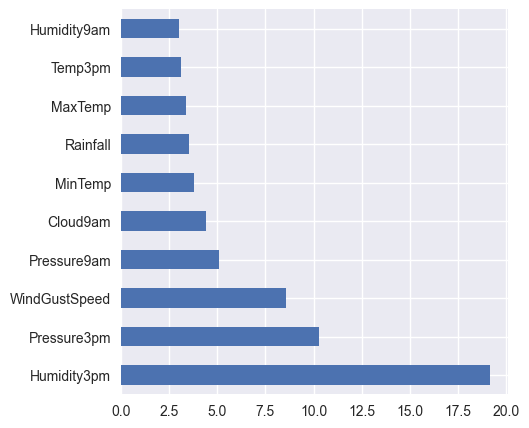

In [70]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(cbc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh');

Наиболее важными для этой модели признаками оказались показания влажности и давления в три часа дня, а также максимальная скорость ветра за последние 24 часа.